In [1]:
from google.colab import drive
drive.mount('/content/drive') 

In [2]:
# Necessary insulations and libraries
!pip install h5py
!pip install typing-extensions
!pip install wheel

!pip install noisereduce
!pip install pydub
!pip uninstall tensorflow
!pip uninstall tensorflow-gpu
!pip uninstall tensorflow-io
!pip install tensorflow 
!pip install --no-deps tensorflow-io

In [5]:
import os
import time
import noisereduce as nr
from scipy.io import wavfile # for audio WAV format
import matplotlib.pyplot as plt

import librosa
import librosa.display

from pydub import AudioSegment 
from pydub.utils import make_chunks

In [ ]:
#Helper function to perform required preprocessing

#Processing audio clips to create 3 second chunks
def process_audio(filename):
    myaudio = AudioSegment.from_file(filename, "wav") 
    chunk_length_ms = 3000
    chunks = make_chunks(myaudio,chunk_length_ms)  
    print(len(chunks))
    for i, chunk in enumerate(chunks):
        filename = os.path.splitext(filename)[0]
        chunk_name = './chunked/' + filename + "_{0}.wav".format(i) 
        chunk.export(chunk_name, format="wav")

#Eliminiting noise fron audio clips
def eliminate_noise(path, filename):
    audio, sample_rate = librosa.load(path)
    reduced_noise = nr.reduce_noise(y=audio, sr=sample_rate)
    filename = os.path.splitext(filename)[0]
    wavfile.write('./reduced/' + filename + "_reduced.wav", sample_rate, reduced_noise)

#Converts audio clips to spectrograms 
def convert_to_spec(path, filename):
    x, sr = librosa.load(path)
    filename = os.path.splitext(filename)[0]
    fname = './images/' + filename + '.png'
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig = plt.figure(frameon = False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fin = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    fig.savefig(fname, dpi='figure')
    plt.close();

In [ ]:
#This function loads an audio clip and resamples it to 16000 samples/second
# import librosa    
import os
import csv
import pandas as pd
import datetime
from itertools import groupby
from matplotlib import pyplot as plt

import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    # wav, s = librosa.load(filename, sr=16000)
 

    return wav

In [ ]:
#Tensorflow only works with 16-bit .wav files
#This function converts them into 16-bit and stores them to the target directory

import soundfile
import os

def convertTo16Bit(directory):
    for file in os.listdir(directory):
         if(file.endswith('.wav')):
                nameSolo = file.rsplit('.', 1)[0]
                path = directory + '/' + file
                #print(directory + f'/{nameSolo}')
                data, samplerate = soundfile.read(path)

                soundfile.write('/content/Test16BIT' + nameSolo + '_16BIT.wav', data, samplerate, subtype='PCM_16')
                #print("converting " + file + "to 16 - bit")

In [ ]:
convertTo16Bit('/content/Test')

In [6]:
#check for existance of data/sample(if not, then create it)
newpath = r'data/sample' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
#  ______________________________________
# |                                      |
# |    This Block for Creating Datasets. |
# |______________________________________|

# NOTE: add the 16BIT audio clip to data/sample to create the dataset
cwd = os.listdir('data')

for folder in cwd:
    
    data_path = './data/'+folder
    os.chdir(data_path)
    
    try:
        os.makedirs('chunked')
        os.makedirs('reduced')
        os.makedirs('images')
    except:
        pass
    
    #start_time = time.perf_counter()
    
    audio_file = os.listdir()
    for file in audio_file:
        if ('.wav' in file):
            process_audio(file)
    print("Audio Splitting Complete")
    
    #print(time.perf_counter() - start_time, "seconds")
    
    #start_time = time.perf_counter()
    
    chunked_files = os.listdir('chunked')
    for file in chunked_files:
        path = "./chunked/"+ file
        eliminate_noise(path, file)
    print("Eliminated Noise")
    
    #print(time.perf_counter() - start_time, "seconds")
    
    #start_time = time.perf_counter()
    
    reduced_files = os.listdir('reduced')
    for file in reduced_files:
        path = "./reduced/"+ file
        convert_to_spec(path, file)
    print("Spectrograms Generated")
    
    #print(time.perf_counter() - start_time, "seconds")
    
    os.chdir('../') 
    os.chdir('../') 

print("Preprocessing Complete")

1200
Audio Splitting Complete
Eliminated Noise
Spectrograms Generated
Audio Splitting Complete
Eliminated Noise
Spectrograms Generated
Preprocessing Complete


# Main model building
### Test16BITSMM07257_20221118_163302_annotated_16BIT.wav

In [ ]:
#upload moan data (3 sec audio), then create Moan folder, then move them to Moan folder
!mv /content/*.wav /content/Saw

mv: target '/content/Saw' is not a directory


In [ ]:
!mv /content/*.wav /content/NoSaw

In [ ]:
#Storing samples from each class for test runs

LEOPARD_FILE = "/content/drive/MyDrive/Leopard/Saw/Test16BITSMM07257_20221118_033302_16BIT_621.wav"
NOT_LEOPARD_FILE = "/content/drive/MyDrive/Leopard/NoSaw/Test16BITSMM07257_20221118_063302_16BIT_137.wav"

In [ ]:
#Loading test files and assigning them to variables
wave = load_wav_16k_mono(LEOPARD_FILE)
nwave= load_wav_16k_mono(NOT_LEOPARD_FILE)

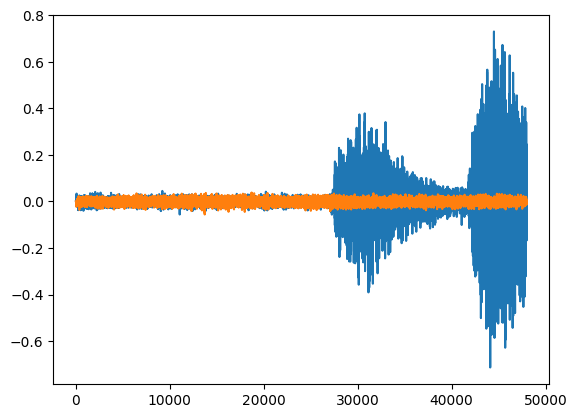

In [ ]:
#Plotting example positive and negative samples
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
#This creates a dataset from the positive and negative samples and loads them onto two variables

# this the folder for the imgs
pos = tf.data.Dataset.list_files('/content/drive/MyDrive/Leopard/Saw/*.wav')
neg = tf.data.Dataset.list_files('/content/drive/MyDrive/Leopard/NoSaw/*.wav')

In [7]:
len(pos), len(neg)

In [8]:
#Adding samples labels to each sample set. potsitive examples are assigned label '1' and negative samples are assigned label '0'
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#Consolidating all samples under one variable sequentially
data = positives.concatenate(negatives)
data.as_numpy_iterator().next() , len(data)

In [ ]:
#This function loads an audio clip and converts it to a spectrogram for further processing

def preprocess(file_path, label): 
    print(file_path)
    wav = load_wav_16k_mono(file_path)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=320, window_fn=None)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    print(spectrogram.shape, label)
    return spectrogram, label

b'/content/drive/MyDrive/Leopard/Saw/Test16BITSMM07257_20221119_053302_16BIT_896.wav'  |  1.0
b'/content/drive/MyDrive/Leopard/Saw/Test16BITSMM07257_20221119_053302_16BIT_896.wav'
(150, 257, 1) 1.0


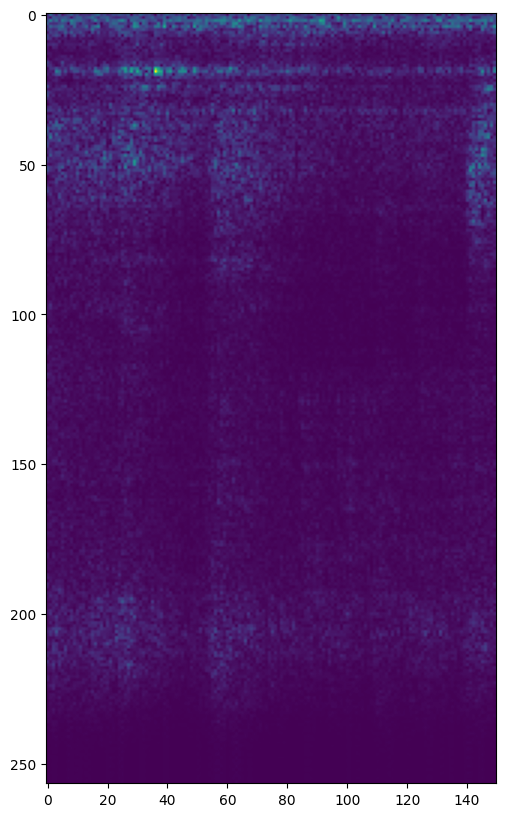

In [ ]:
#Extracting one sample and plotting it's spectrogram for analysis

filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(filepath, " | ", label)
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(20,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [9]:
#Creating a data loading pipeline, that shuffles the dataset and creates batches of 16 images

# data = tf.data.Dataset.map(preprocess)
data= data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
# new data size after batch was created
len(data)

13

In [ ]:
#Splitting dataset into train and test sets
train = data.take(10)
test = data.skip(10).take(3)

In [ ]:
len(train),len(test)

(10, 3)

In [ ]:
#Extracting random example from train set
samples, labels = train.as_numpy_iterator().next()

In [ ]:
#Outputs shape of example train sample. 
#This gives the input_shape for the Convolutional Neural Network
samples.shape

(16, 150, 257, 1)

In [ ]:
#Creating a sequential convolutional neural network model

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(150,257,1)))
model.add(Conv2D(5, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#Model compilation
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])

In [ ]:
#Outputs model summary and model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 253, 5)       725       
                                                                 
 flatten (Flatten)           (None, 184690)            0         
                                                                 
 dense (Dense)               (None, 128)               23640448  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,641,462
Trainable params: 23,641,462
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Initiating training instance and storing results in 'hist' variable
hist = model.fit(train, epochs=200, validation_data=test)

In [11]:
#Plotting accuracy
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [12]:
#Plotting Loss
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [13]:
#Plotting Precision
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [16]:
#Plotting Recall
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
#Extracting an example from the test set to check model performance
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
#Testing model by making prediction from extracted test sample
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat)
print(y_test)


1/1 [==============================] - 0s 372ms/step
[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]


## Build Function to Convert Clips to Spectrograms

In [ ]:
#check for existance of Clips-Leopard(if not, then create it)
newpath = r'Clips-Leopard' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
#move all the clips to Clips-Leopard
!mv /content/*.wav /content/Clips-Leopard

In [ ]:
#check for existance of Converted_16BIT (if not, then create it)
newpath = r'Converted_16BIT' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
convertTo16Bit("/content/Clips-Leopard")

In [ ]:
#move all the clips that converted to 16BIT to Converted_16BIT
!mv /content/*.wav /content/Converted_16BIT

In [ ]:
#This function performs required preprocessing for test dataset
def preprocess_dataset(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=320)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [17]:
import os
import datetime
import pandas as pd
import numpy as np

results = {}
time = []
NumCalls = []

for filename in os.listdir("/content/Converted_16BIT/"):
    if filename.endswith(".wav"): 
        #Testing functions that will be used to ensure correctness
        RECORDING = os.path.join('Converted_16BIT',str(filename))
        wav = load_wav_16k_mono(RECORDING)
        audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
        audio_slices = audio_slices.map(preprocess_dataset)
        #print(len(audio_slices)) # 1199 Whole clip 3 sec each
        audio_slices = audio_slices.batch(16)
        
        
        #print(audio_slices) # shape
        yhat = model.predict(audio_slices)
        yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
        
   

        results[filename] = yhat
        #search for Saws in a clip and convert the 3 sec index to the actual time in the clip
        listOfSaws = list(results[filename])
        print(filename)
        print()

        #print(len(audio_slices)) # 75 which is 1199/16 = ~75
        iterator = iter(audio_slices)
        #print(iterator.get_next().shape[0]) # 16 
          
        batch = iterator.get_next()
        for count, value in enumerate(listOfSaws):
         
          if value == 0:
            #print("Index " + str(count) + " | Audio Clip Time Interval " + str(datetime.timedelta(seconds=int(count*3))))
            time.append([str(count), str(datetime.timedelta(seconds=int(count*3)))])

            print("COUNT ", count)
            index = count % 16 # 16 is the batch size
            
            images = batch[index]
            images = images[np.newaxis,...] # add 1D so we can match the CNN input shape
              
            images = tf.Variable(images, dtype=float)
            with tf.GradientTape() as tape:
              pred = model(images, training=False)
              class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
              loss = pred[0][class_idxs_sorted[0]]
                
            grads = tape.gradient(loss, images)
            dgrad_abs = tf.math.abs(grads)
            dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
            ## normalize to range between 0 and 1
            arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
            grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
            plt.imshow(grad_eval)
            plt.show()  

            if count % 16 == 0 : # when we finish each batch we iterate to next 
              batch = iterator.get_next()
              
            
        df = pd.DataFrame(time, columns=['Index', 'Audio Clip Time Interval'])
        df.to_csv(str(filename.split(".")[0]) + ".csv")
        print(df)
        #Grouping class predictions and storing call density in 'calls' variable
        yhat = [key for key, group in groupby(yhat)]
        calls = tf.math.reduce_sum(yhat).numpy()
        print(calls)
        NumCalls.append([str(filename), calls])
        time = []
        print("=================================================")
        print()
dfCalls = pd.DataFrame(NumCalls, columns=['Clip Name', 'Num of Calls'])
dfCalls.to_csv("TotalCallsPerClip.csv")

In [ ]:
#Put all the CSV files that was created from auto annotations
newpath = r'Results' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
#move all CSV files to the Results folder
!mv /content/*.csv /content/Results